# Synthetic Marketing Data Generator

        date  tv_spend  search_spend  social_spend  email_spend  print_spend  \
0 2022-01-02   9838.71       5257.52       3412.71      2310.23      3499.18   
1 2022-01-09  11012.56       6955.49       3406.75      2153.64      4143.59   
2 2022-01-16  13094.15       5343.70       3652.74      2489.71      3762.38   
3 2022-01-23  11964.04       5655.16       8010.50      2376.82      4112.93   
4 2022-01-30  12601.92       5593.51       8340.98      2865.12      3693.35   

      sales  competitor_activity  economic_factor  events  week_of_year  \
0   9435.40              2389.78          -269.88     0.0            52   
1  10580.95              -766.82          -297.78     0.0             1   
2  17203.85             -1484.41           279.91  5000.0             2   
3  12487.63              -188.68          -218.11     0.0             3   
4  12989.10                83.59           562.02     0.0             4   

   month  quarter  total_spend  
0      1        1     24318.35  
1 

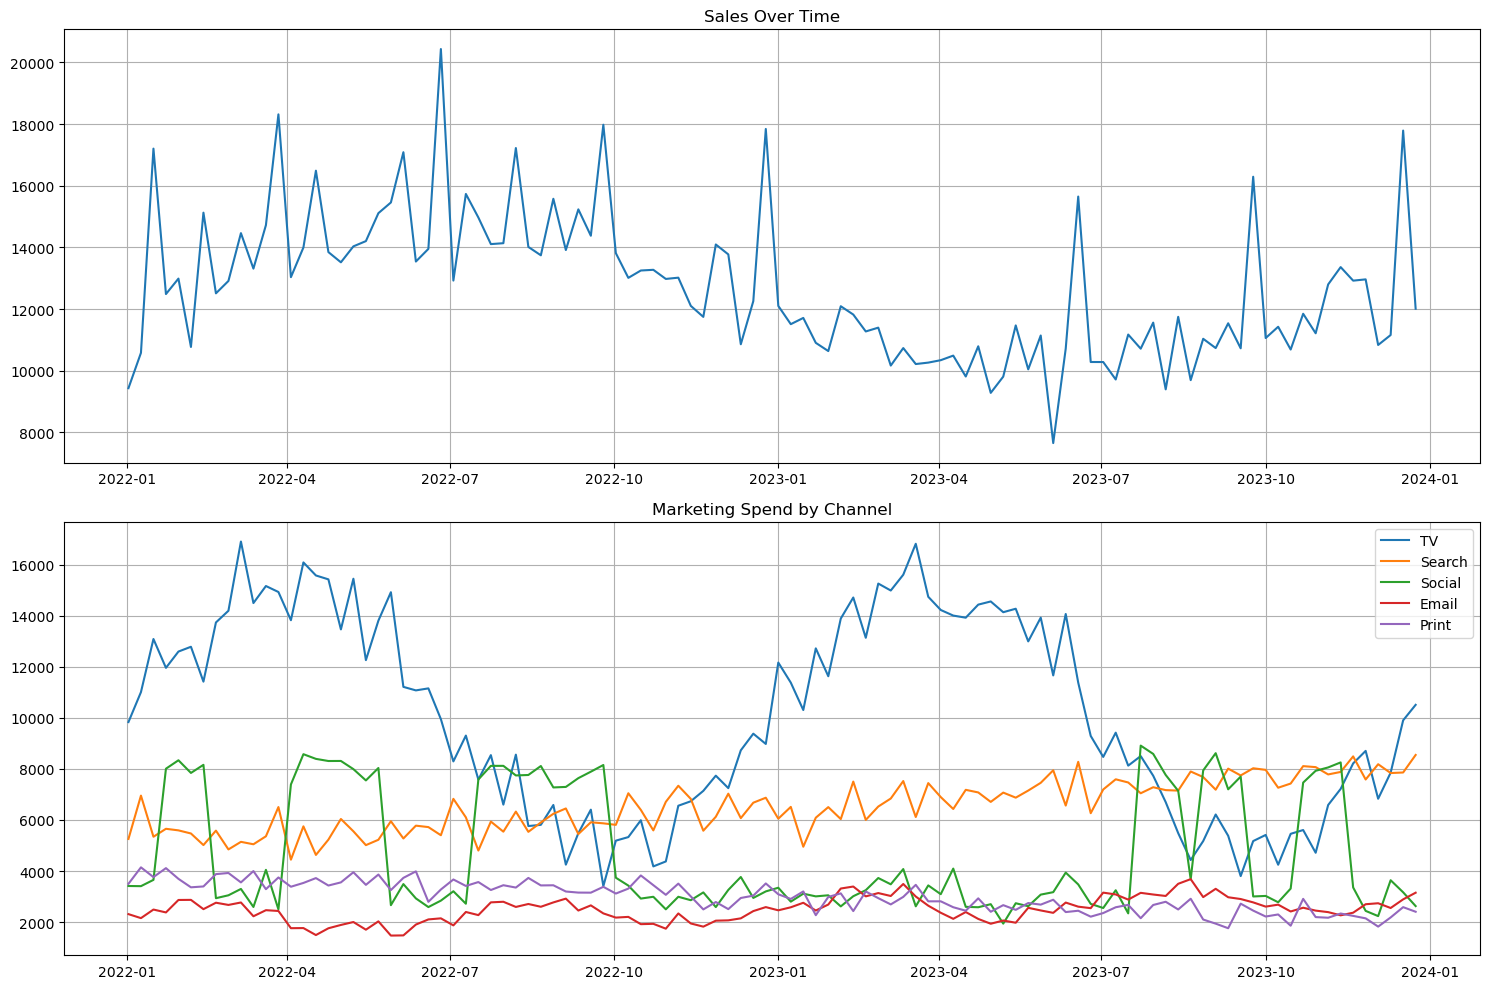

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import seaborn as sns

def generate_synthetic_mmm_data(start_date='2022-01-01', periods=104, seed=42):
    """
    Generate synthetic marketing mix modeling data.
    
    Parameters:
    - start_date: Starting date for the time series
    - periods: Number of periods (weeks) to generate
    - seed: Random seed for reproducibility
    
    Returns:
    - DataFrame with date and various marketing channels and sales data
    """
    np.random.seed(seed)
    random.seed(seed)
    
    # Create date range (weekly data)
    date_range = pd.date_range(start=start_date, periods=periods, freq='W')
    
    # Initialize DataFrame with dates
    df = pd.DataFrame({'date': date_range})
    
    # Base sales (without marketing)
    base_sales = 10000 + np.random.normal(0, 500, periods)
    
    # Create marketing channel spends with realistic patterns
    # TV ads with seasonality
    tv_spend_base = np.sin(np.linspace(0, 4*np.pi, periods)) * 5000 + 10000
    tv_spend = np.maximum(0, tv_spend_base + np.random.normal(0, 1000, periods))
    
    # Search ads with steady increase and weekly variations
    search_trend = np.linspace(5000, 8000, periods)
    search_noise = np.random.normal(0, 500, periods)
    search_spend = search_trend + search_noise
    
    # Social media with occasional spikes (campaigns)
    social_spend_base = np.ones(periods) * 3000
    campaign_weeks = random.sample(range(periods), 10)  # 10 random campaign weeks
    for week in campaign_weeks:
        social_spend_base[week:week+4] = 8000  # 4-week campaigns
    social_spend = social_spend_base + np.random.normal(0, 500, periods)
    
    # Email marketing (periodic with gradual growth)
    email_base = 2000 + np.linspace(0, 1000, periods)
    email_seasonal = np.sin(np.linspace(0, 8*np.pi, periods)) * 500
    email_spend = email_base + email_seasonal + np.random.normal(0, 200, periods)
    
    # Traditional print media (declining)
    print_spend = np.linspace(4000, 2000, periods) + np.random.normal(0, 300, periods)
    
    # Define marketing channel effects (coefficients)
    # These represent how effective each channel is at driving sales
    tv_effect = 1.5       # High impact but with diminishing returns
    search_effect = 2.0   # High efficiency
    social_effect = 1.2   # Moderate impact
    email_effect = 3.0    # Very efficient per dollar
    print_effect = 0.5    # Low impact
    
    # Add carryover effects (marketing impact lasts multiple periods)
    tv_carryover = 0.7    # 70% of effect carries to next period
    search_carryover = 0.3
    social_carryover = 0.5
    email_carryover = 0.2
    print_carryover = 0.4
    
    # Apply diminishing returns using square root transformation
    tv_contribution = tv_effect * np.sqrt(tv_spend)
    search_contribution = search_effect * np.sqrt(search_spend)
    social_contribution = social_effect * np.sqrt(social_spend)
    email_contribution = email_effect * np.sqrt(email_spend)
    print_contribution = print_effect * np.sqrt(print_spend)
    
    # Initialize arrays for adstock (carryover) effects
    tv_adstock = np.zeros(periods)
    search_adstock = np.zeros(periods)
    social_adstock = np.zeros(periods)
    email_adstock = np.zeros(periods)
    print_adstock = np.zeros(periods)
    
    # Calculate adstock effects
    for i in range(periods):
        if i == 0:
            tv_adstock[i] = tv_contribution[i]
            search_adstock[i] = search_contribution[i]
            social_adstock[i] = social_contribution[i]
            email_adstock[i] = email_contribution[i]
            print_adstock[i] = print_contribution[i]
        else:
            tv_adstock[i] = tv_contribution[i] + tv_carryover * tv_adstock[i-1]
            search_adstock[i] = search_contribution[i] + search_carryover * search_adstock[i-1]
            social_adstock[i] = social_contribution[i] + social_carryover * social_adstock[i-1]
            email_adstock[i] = email_contribution[i] + email_carryover * email_adstock[i-1]
            print_adstock[i] = print_contribution[i] + print_carryover * print_adstock[i-1]
    
    # Create seasonality component
    seasonality = np.sin(np.linspace(0, 2*np.pi, periods)) * 3000
    
    # Generate competitor activity (affects market share)
    competitor_activity = np.random.normal(0, 1500, periods)
    
    # Create trend component (gradual market growth)
    trend = np.linspace(0, 2000, periods)
    
    # Generate external factors (e.g., economic indicators)
    economic_factor = np.sin(np.linspace(0, 3*np.pi, periods)) * 1000 + np.random.normal(0, 500, periods)
    
    # Special events like holidays or promotions
    events = np.zeros(periods)
    holiday_weeks = [2, 12, 25, 38, 51, 76, 90, 102]  # Example holiday weeks
    for week in holiday_weeks:
        events[week] = 5000  # Boost during holiday weeks
    
    # Calculate total sales
    sales = (
        base_sales +
        tv_adstock +
        search_adstock +
        social_adstock +
        email_adstock +
        print_adstock +
        seasonality +
        competitor_activity * -0.3 +  # Competitor activity negatively affects sales
        trend +
        economic_factor * 0.5 +
        events
    )
    
    # Ensure no negative sales
    sales = np.maximum(sales, 0)
    
    # Add 5% random noise to sales
    noise = np.random.normal(0, sales * 0.05)
    sales = sales + noise
    
    # Add data to DataFrame
    df['tv_spend'] = tv_spend.round(2)
    df['search_spend'] = search_spend.round(2)
    df['social_spend'] = social_spend.round(2)
    df['email_spend'] = email_spend.round(2)
    df['print_spend'] = print_spend.round(2)
    df['sales'] = sales.round(2)
    df['competitor_activity'] = competitor_activity.round(2)
    df['economic_factor'] = economic_factor.round(2)
    df['events'] = events
    
    # Create a week_of_year feature for seasonality
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    # Create month and quarter features
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    
    # Total marketing spend
    df['total_spend'] = df['tv_spend'] + df['search_spend'] + df['social_spend'] + df['email_spend'] + df['print_spend']
    
    return df

# Generate the data
mmm_data = generate_synthetic_mmm_data(periods=104)  # 2 years of weekly data

# Save to CSV
mmm_data.to_csv('synthetic_mmm_data.csv', index=False)

# Display first few rows
print(mmm_data.head())

# Plot the data
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(mmm_data['date'], mmm_data['sales'])
plt.title('Sales Over Time')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(mmm_data['date'], mmm_data['tv_spend'], label='TV')
plt.plot(mmm_data['date'], mmm_data['search_spend'], label='Search')
plt.plot(mmm_data['date'], mmm_data['social_spend'], label='Social')
plt.plot(mmm_data['date'], mmm_data['email_spend'], label='Email')
plt.plot(mmm_data['date'], mmm_data['print_spend'], label='Print')
plt.title('Marketing Spend by Channel')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('marketing_and_sales.png')
plt.show()

# Basic Marketing Mix Model

Running basic Marketing Mix Model...
Data shape: (104, 14)

Data summary:
                      date      tv_spend  search_spend  social_spend  \
count                  104    104.000000    104.000000    104.000000   
mean   2022-12-28 12:00:00  10067.117500   6532.201827   4707.102692   
min    2022-01-02 00:00:00   3407.050000   4445.010000   1938.050000   
25%    2022-07-01 06:00:00   6599.117500   5705.155000   2924.860000   
50%    2022-12-28 12:00:00   9872.620000   6510.385000   3381.280000   
75%    2023-06-26 18:00:00  13847.057500   7298.875000   7655.662500   
max    2023-12-24 00:00:00  16914.810000   8549.390000   8915.730000   
std                    NaN   3797.809829   1006.587966   2363.770692   

       email_spend  print_spend         sales  competitor_activity  \
count   104.000000   104.000000    104.000000           104.000000   
mean   2492.844038  2997.246923  12717.023365          -139.052885   
min    1469.650000  1757.650000   7655.030000         -4045.330000 

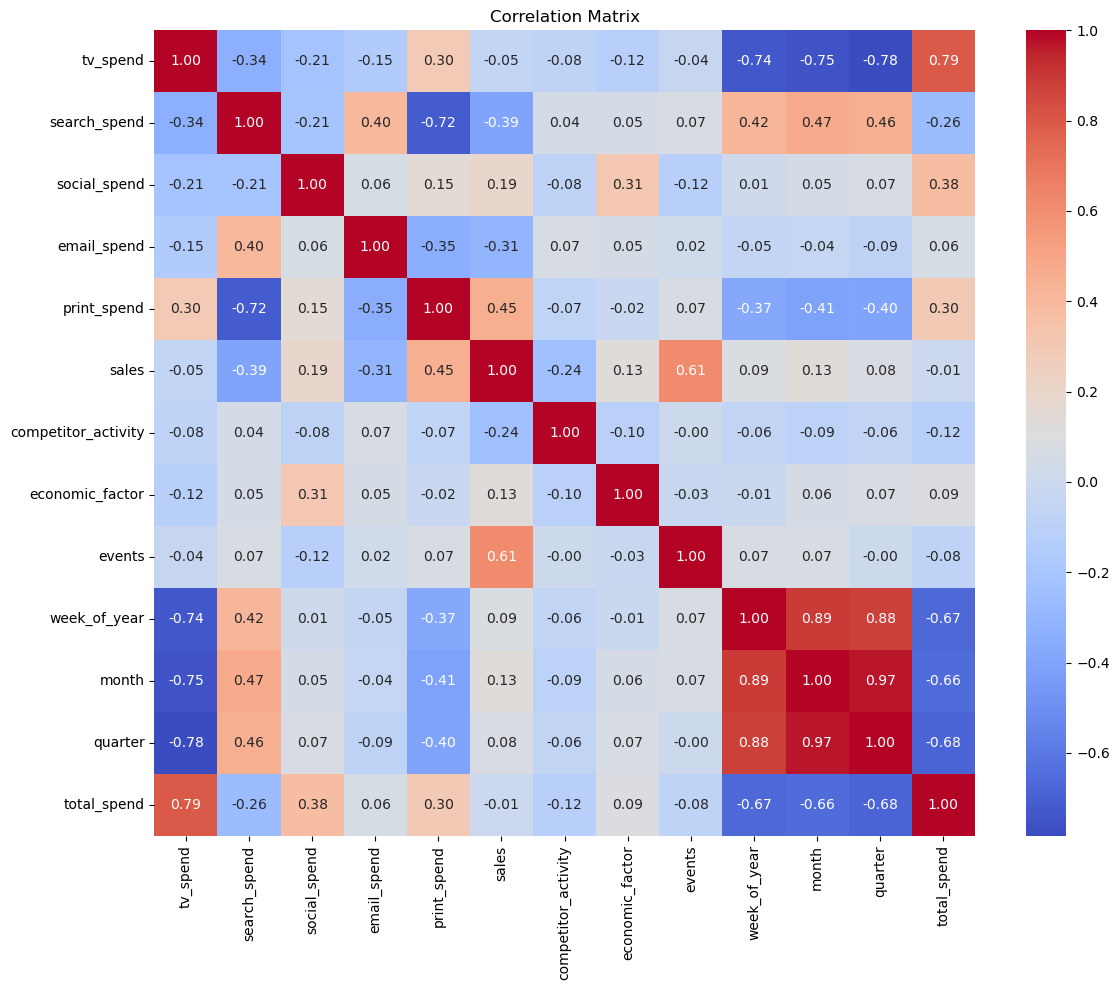

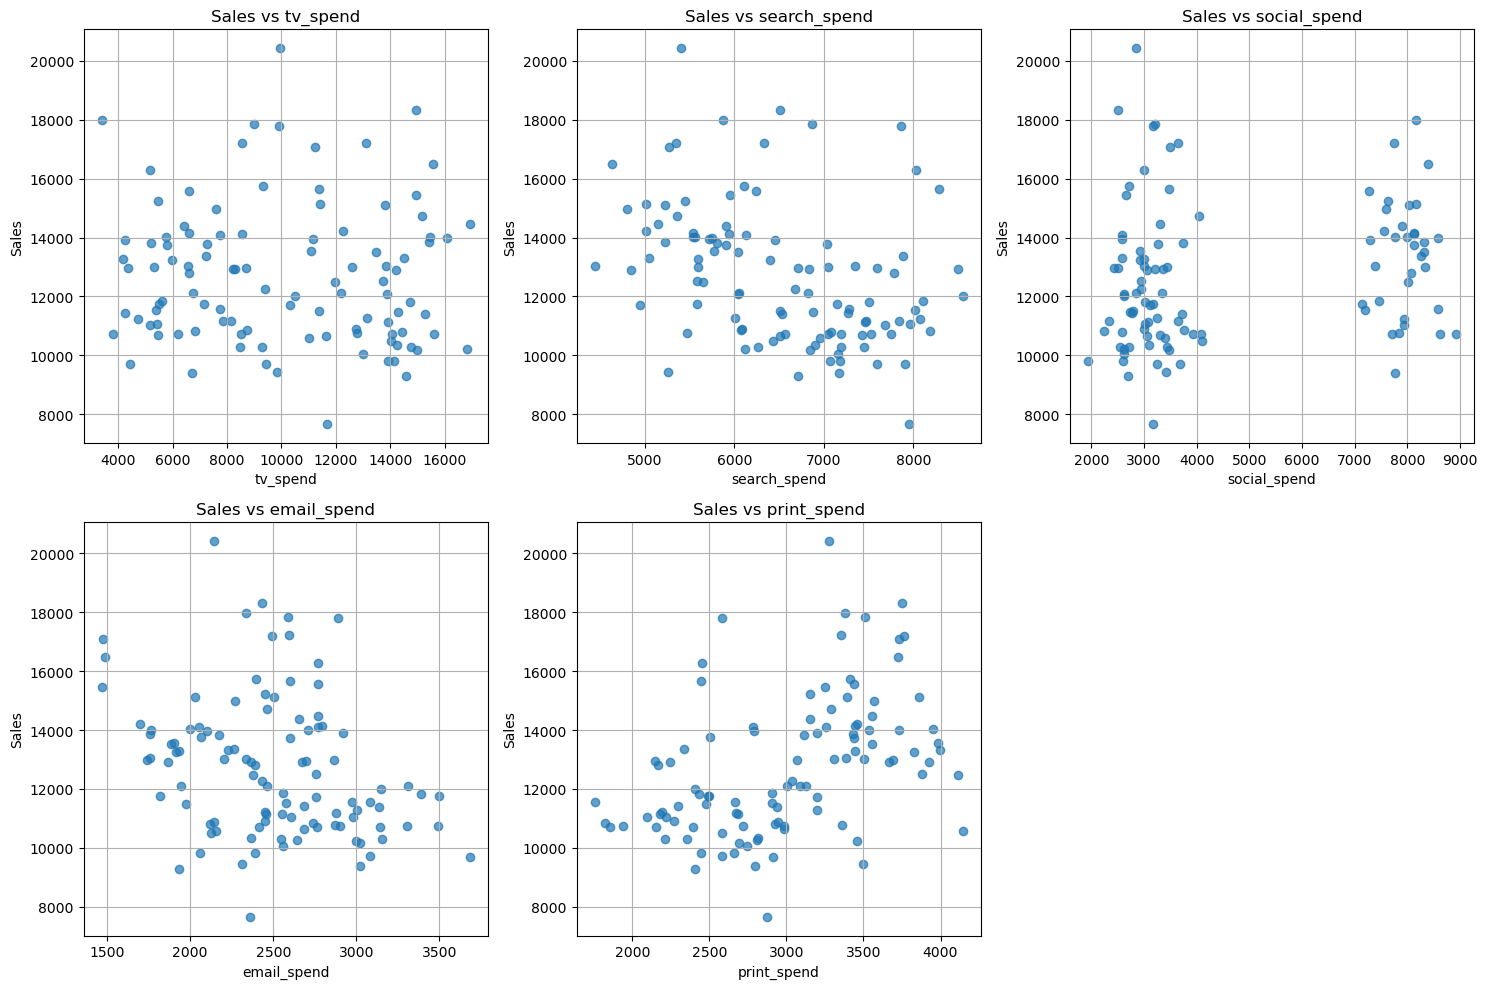

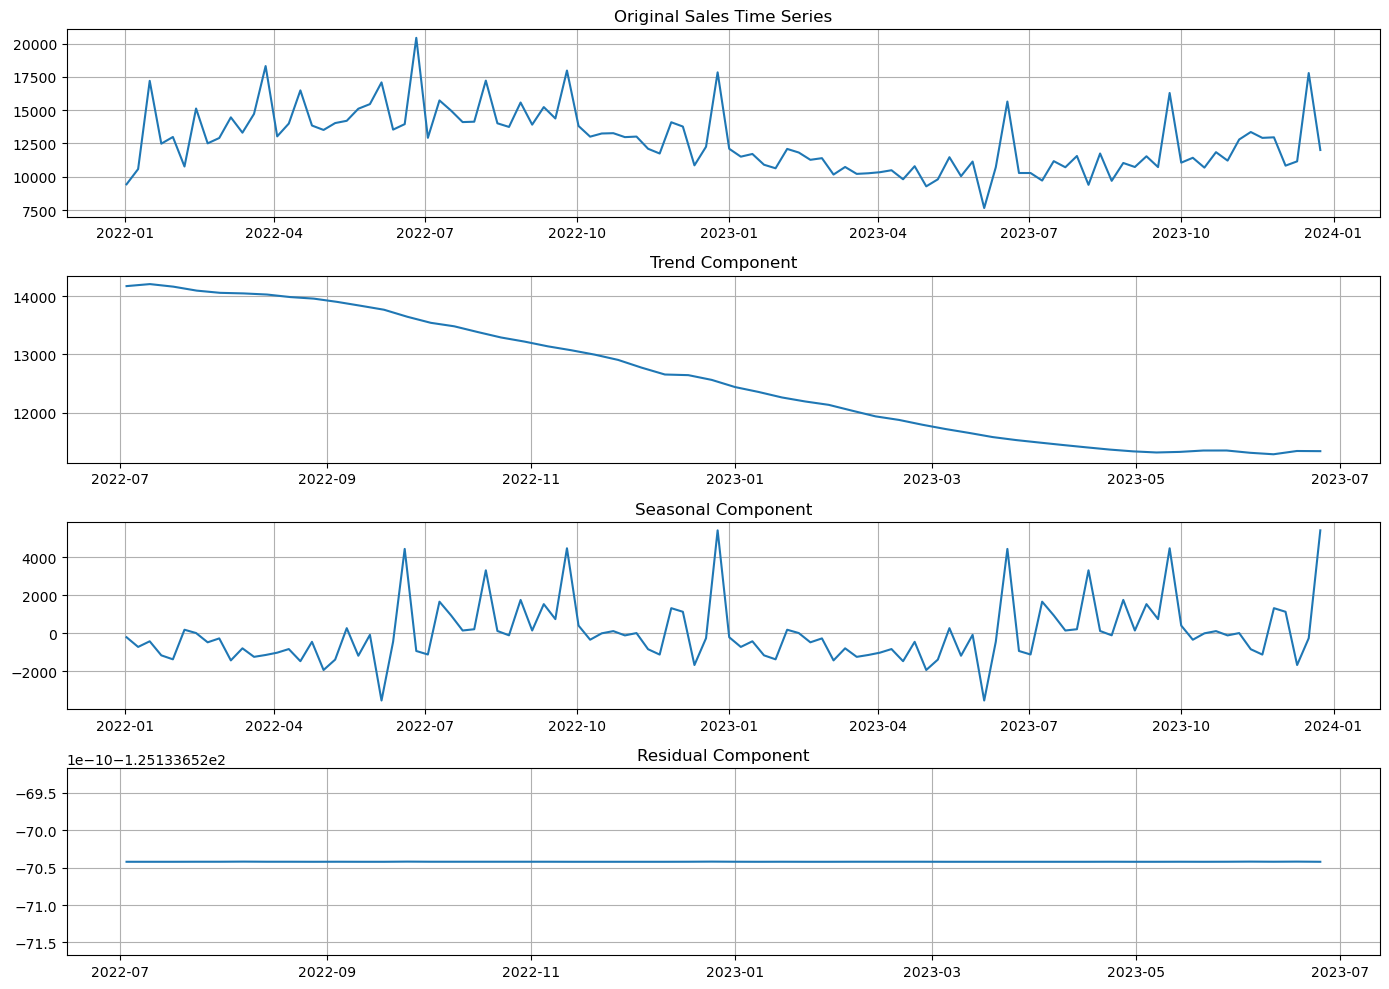

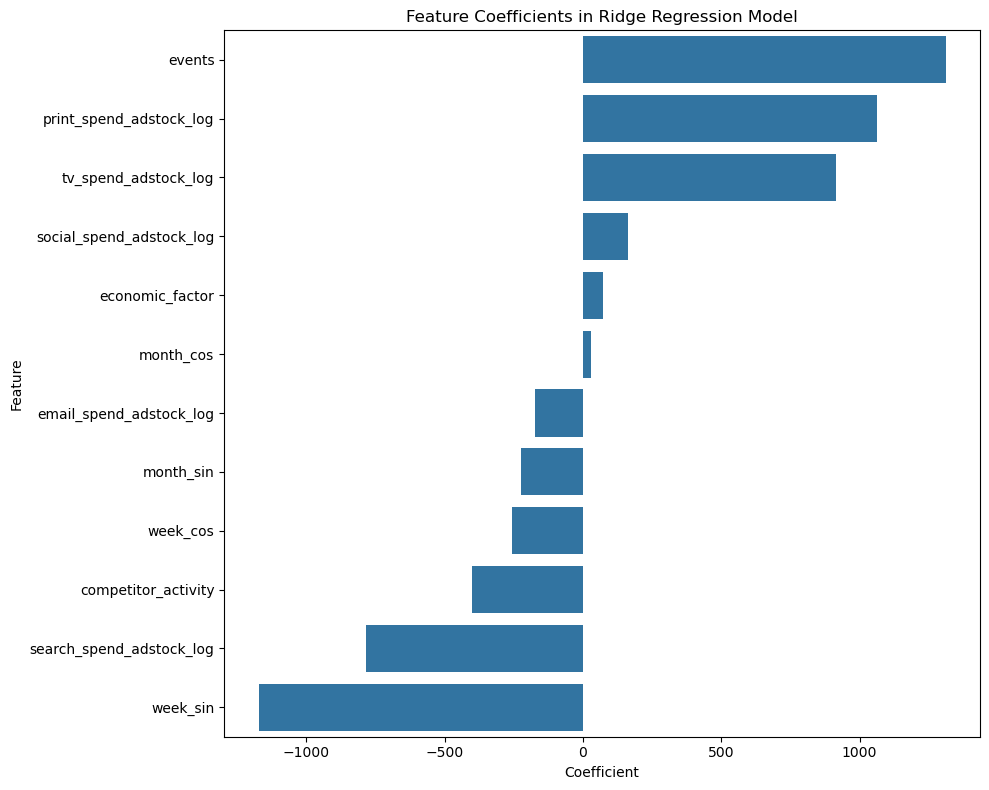

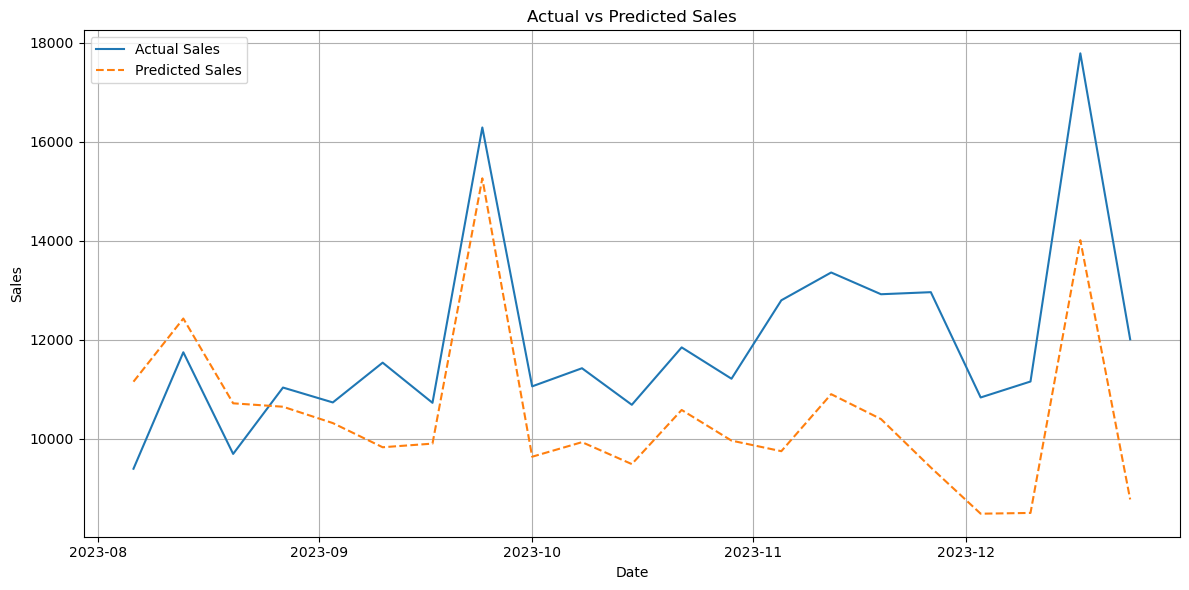

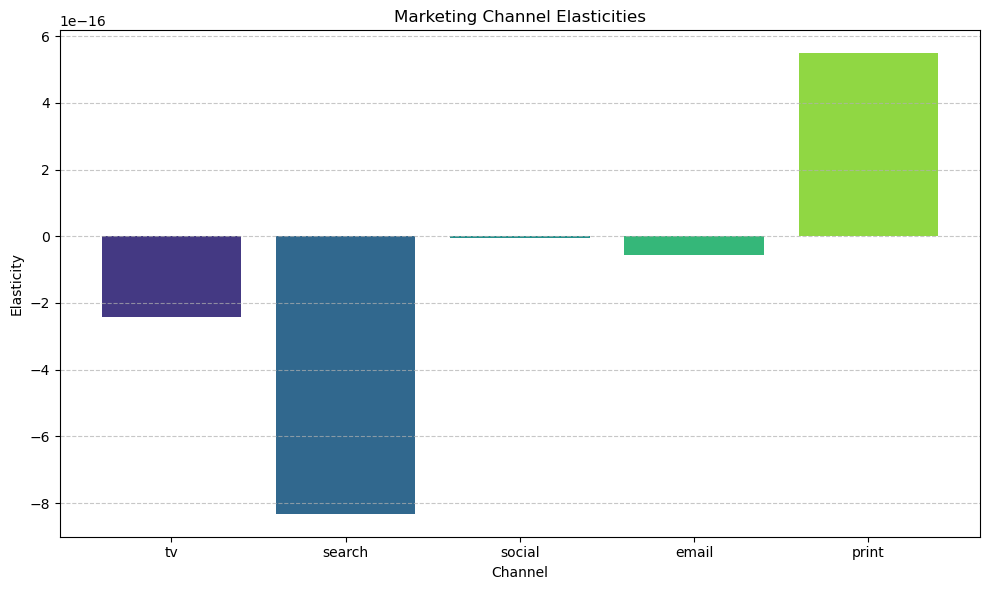

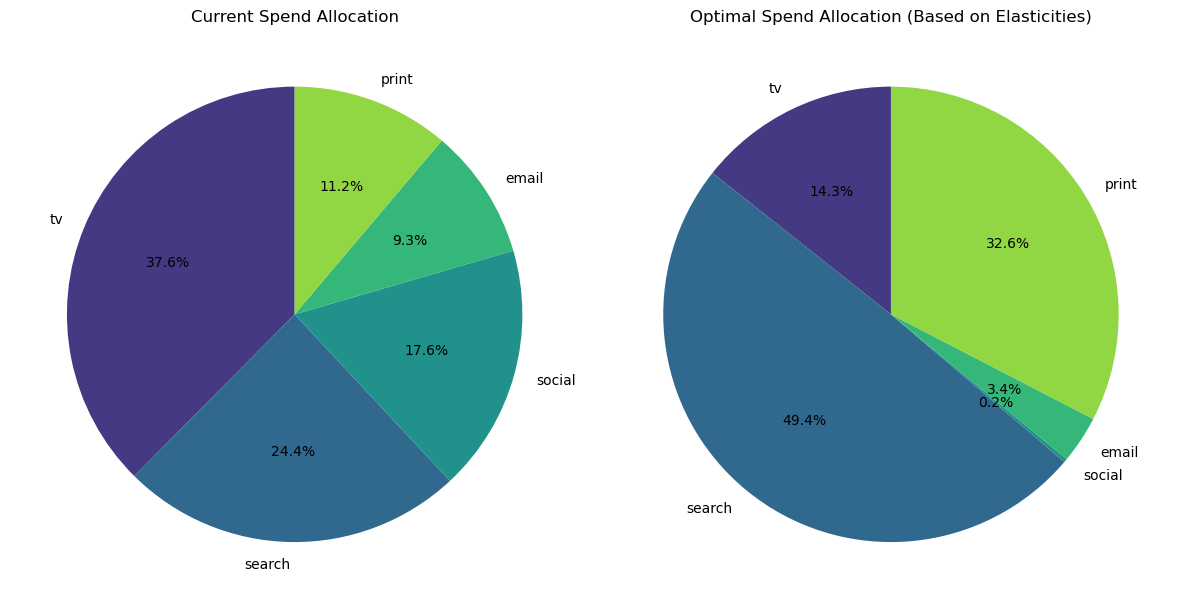

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

def run_basic_mmm(data):
    """
    Run a basic Marketing Mix Model on the provided data.
    
    Parameters:
    - data: DataFrame with marketing and sales data
    
    Returns:
    - Dictionary of model results
    """
    print("Running basic Marketing Mix Model...")
    
    # Exploratory Data Analysis
    print("Data shape:", data.shape)
    print("\nData summary:")
    print(data.describe())

    # Check for missing values
    print("\nMissing values:")
    print(data.isnull().sum())

    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = data.drop('date', axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')

    # Plot spend vs sales scatter plots
    plt.figure(figsize=(15, 10))
    channels = ['tv_spend', 'search_spend', 'social_spend', 'email_spend', 'print_spend']

    for i, channel in enumerate(channels, 1):
        plt.subplot(2, 3, i)
        plt.scatter(data[channel], data['sales'], alpha=0.7)
        plt.title(f'Sales vs {channel}')
        plt.xlabel(channel)
        plt.ylabel('Sales')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('spend_vs_sales.png')

    # Time series decomposition
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Decompose the sales time series
    result = seasonal_decompose(data['sales'], model='additive', period=52)  # 52 weeks per year

    # Plot the decomposition
    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(data['date'], data['sales'])
    plt.title('Original Sales Time Series')
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(data['date'], result.trend)
    plt.title('Trend Component')
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.plot(data['date'], result.seasonal)
    plt.title('Seasonal Component')
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.plot(data['date'], result.resid)
    plt.title('Residual Component')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('time_series_decomposition.png')

    # Create adstock transformations for marketing variables
    def adstock_transformation(x, decay_rate=0.7, lag=4):
        """
        Apply adstock transformation to marketing variables to account for 
        carryover effects (the impact of marketing persisting over time).
        
        Parameters:
        - x: array-like, the original marketing variable
        - decay_rate: float between 0 and 1, how much effect carries over to next period
        - lag: int, number of periods to consider for carryover effect
        
        Returns:
        - array-like, transformed variable with adstock effect
        """
        x_array = np.array(x)
        adstocked = np.zeros_like(x_array)
        
        for i in range(len(x_array)):
            # Sum up the decayed effect from current and previous periods
            for l in range(min(i+1, lag)):
                adstocked[i] += x_array[i-l] * (decay_rate ** l)
        
        return adstocked

    # Apply adstock transformations
    for channel in channels:
        data[f'{channel}_adstock'] = adstock_transformation(data[channel], decay_rate=0.7)

    # Apply diminishing returns transformations using a simple log transformation
    for channel in channels:
        # Add small constant to avoid log(0)
        data[f'{channel}_log'] = np.log1p(data[channel])
        data[f'{channel}_adstock_log'] = np.log1p(data[f'{channel}_adstock'])
        
        # Also try square root transformation
        data[f'{channel}_sqrt'] = np.sqrt(data[channel])
        data[f'{channel}_adstock_sqrt'] = np.sqrt(data[f'{channel}_adstock'])

    # Create seasonal features
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

    # Prepare features for modeling
    # We'll use adstock and log-transformed features
    features = [
        # Adstocked and log-transformed marketing variables
        'tv_spend_adstock_log',
        'search_spend_adstock_log',
        'social_spend_adstock_log',
        'email_spend_adstock_log',
        'print_spend_adstock_log',
        
        # Control variables
        'competitor_activity',
        'economic_factor',
        'events',
        
        # Seasonal features
        'month_sin', 'month_cos',
        'week_sin', 'week_cos'
    ]

    X = data[features]
    y = data['sales']

    # Split data chronologically (for time series data)
    train_size = int(len(data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Ridge Regression (with regularization)
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_ridge = ridge_model.predict(X_test_scaled)

    # Evaluate model
    ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    ridge_r2 = r2_score(y_test, y_pred_ridge)

    print(f"\nRidge Regression Results:")
    print(f"RMSE: {ridge_rmse:.2f}")
    print(f"R²: {ridge_r2:.4f}")

    # 2. OLS with statsmodels (for detailed statistical output)
    X_train_sm = sm.add_constant(X_train)
    sm_model = sm.OLS(y_train, X_train_sm).fit()
    print("\nStatsmodels OLS Results Summary:")
    print(sm_model.summary())

    # Plot feature coefficients
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Coefficient': ridge_model.coef_
    })
    feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Coefficients in Ridge Regression Model')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'][train_size:], y_test, label='Actual Sales')
    plt.plot(data['date'][train_size:], y_pred_ridge, label='Predicted Sales', linestyle='--')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')

    # Calculate elasticities for different marketing channels
    def calculate_elasticity(model, feature_idx, X_mean, y_mean):
        """
        Calculate the elasticity for a given feature.
        Elasticity = (% change in output) / (% change in input)
        """
        feature_coef = model.coef_[feature_idx]
        elasticity = feature_coef * (X_mean[feature_idx] / y_mean)
        return elasticity

    # Find the mean values from the training set
    X_train_mean = X_train_scaled.mean(axis=0)
    y_train_mean = y_train.mean()

    # Calculate elasticities for marketing channels
    marketing_features = [
        'tv_spend_adstock_log',
        'search_spend_adstock_log',
        'social_spend_adstock_log',
        'email_spend_adstock_log',
        'print_spend_adstock_log'
    ]

    # Modified to store with full feature names as keys
    elasticities = {}
    for i, feature in enumerate(features):
        if feature in marketing_features:
            elasticities[feature] = calculate_elasticity(ridge_model, i, X_train_mean, y_train_mean)

    # Create simplified channel name mapping
    channel_mapping = {}
    for feature in marketing_features:
        # Extract base channel name (e.g., 'tv' from 'tv_spend_adstock_log')
        base_channel = feature.split('_')[0]
        channel_mapping[feature] = base_channel
        
    # Create a simplified elasticities dictionary
    simple_elasticities = {}
    for feature, elasticity in elasticities.items():
        simple_elasticities[channel_mapping[feature]] = elasticity

    print("\nMarketing Channel Elasticities:")
    for channel, elasticity in simple_elasticities.items():
        print(f"{channel}: {elasticity:.4f}")

    # Plot elasticities
    plt.figure(figsize=(10, 6))
    channels = list(simple_elasticities.keys())
    values = list(simple_elasticities.values())
    colors = sns.color_palette('viridis', len(channels))

    bars = plt.bar(channels, values, color=colors)
    plt.title('Marketing Channel Elasticities')
    plt.xlabel('Channel')
    plt.ylabel('Elasticity')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('elasticities.png')

    # Calculate ROI for each channel
    print("\nROI by Channel (Return per $1 spent):")
    avg_spend = data[['tv_spend', 'search_spend', 'social_spend', 'email_spend', 'print_spend']].mean()

    # Create a simple spend mapping
    spend_mapping = {}
    for column in avg_spend.index:
        # Extract base channel name (e.g., 'tv' from 'tv_spend')
        base_channel = column.split('_')[0]
        spend_mapping[base_channel] = column
        
    for channel, elasticity in simple_elasticities.items():
        # Get the corresponding spend column
        spend_column = spend_mapping[channel]
        # Estimate sales impact per dollar spent
        impact_per_dollar = elasticity * y_train_mean / avg_spend[spend_column]
        print(f"{channel}: ${impact_per_dollar:.2f}")

    # Optimal budget allocation
    # Using the elasticities to determine budget allocation
    total_budget = avg_spend.sum()
    print(f"\nCurrent total weekly marketing budget: ${total_budget:.2f}")

    # Calculate proportion to allocate based on elasticities
    total_elasticity = sum(abs(e) for e in simple_elasticities.values())
    optimal_allocation = {}

    print("\nOptimal Budget Allocation:")
    for channel, elasticity in simple_elasticities.items():
        # Allocate budget proportional to elasticity
        allocation_percent = (abs(elasticity) / total_elasticity) * 100
        allocation_amount = total_budget * (abs(elasticity) / total_elasticity)
        optimal_allocation[channel] = allocation_amount
        print(f"{channel}: ${allocation_amount:.2f} ({allocation_percent:.1f}%)")

    # Plot current vs optimal allocation
    plt.figure(figsize=(12, 6))

    # Current allocation - using simplified channel names
    current_allocation_simple = {}
    for channel, spend_col in spend_mapping.items():
        current_allocation_simple[channel] = avg_spend[spend_col]
        
    # Current allocation
    plt.subplot(1, 2, 1)
    plt.pie(list(current_allocation_simple.values()), 
            labels=current_allocation_simple.keys(), 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=colors)
    plt.title('Current Spend Allocation')

    # Optimal allocation
    plt.subplot(1, 2, 2)
    plt.pie(list(optimal_allocation.values()), 
            labels=optimal_allocation.keys(), 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=colors)
    plt.title('Optimal Spend Allocation (Based on Elasticities)')

    plt.tight_layout()
    plt.savefig('budget_allocation.png')
    
    print("\nAnalysis and visualizations complete!")
    
    # Return results
    return {
        'rmse': ridge_rmse,
        'r2': ridge_r2,
        'elasticities': simple_elasticities,
        'optimal_allocation': optimal_allocation
    }

if __name__ == "__main__":
    # If run as a script, load data and run the model
    data = pd.read_csv('synthetic_mmm_data.csv')
    data['date'] = pd.to_datetime(data['date'])
    run_basic_mmm(data)

# Google Meridian MMM Implementation

Running Meridian-style MMM model...
Loaded marketing mix data with shape: (104, 14)
        date  tv_spend  search_spend  social_spend  email_spend  print_spend  \
0 2022-01-02   9838.71       5257.52       3412.71      2310.23      3499.18   
1 2022-01-09  11012.56       6955.49       3406.75      2153.64      4143.59   
2 2022-01-16  13094.15       5343.70       3652.74      2489.71      3762.38   
3 2022-01-23  11964.04       5655.16       8010.50      2376.82      4112.93   
4 2022-01-30  12601.92       5593.51       8340.98      2865.12      3693.35   

      sales  competitor_activity  economic_factor  events  week_of_year  \
0   9435.40              2389.78          -269.88     0.0            52   
1  10580.95              -766.82          -297.78     0.0             1   
2  17203.85             -1484.41           279.91  5000.0             2   
3  12487.63              -188.68          -218.11     0.0             3   
4  12989.10                83.59           562.02     0.0   

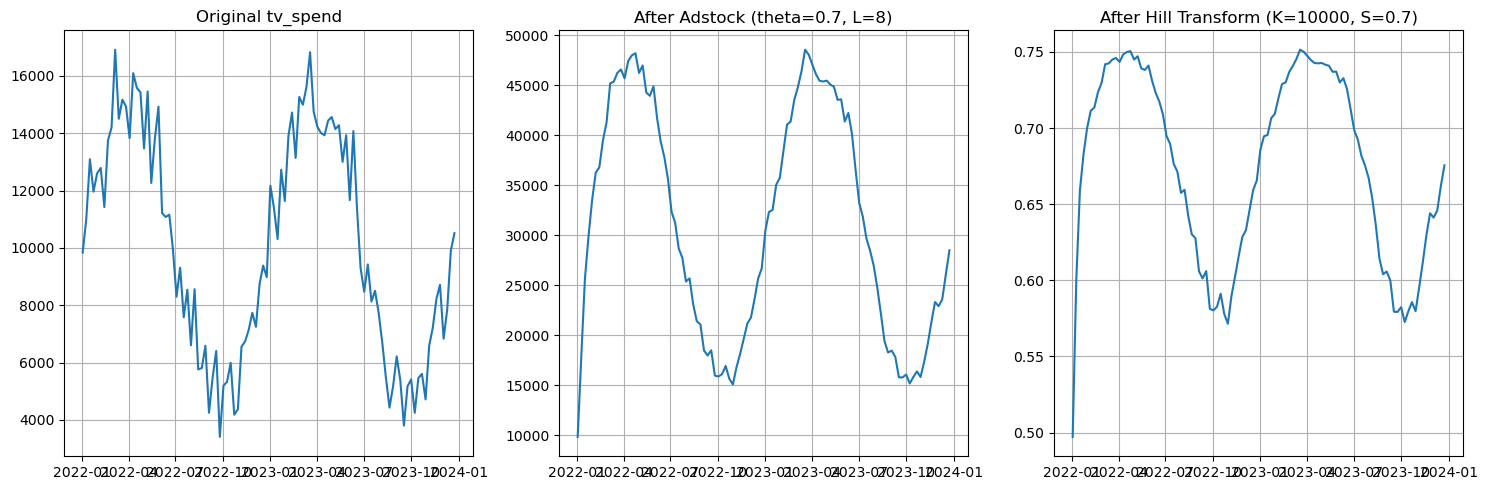

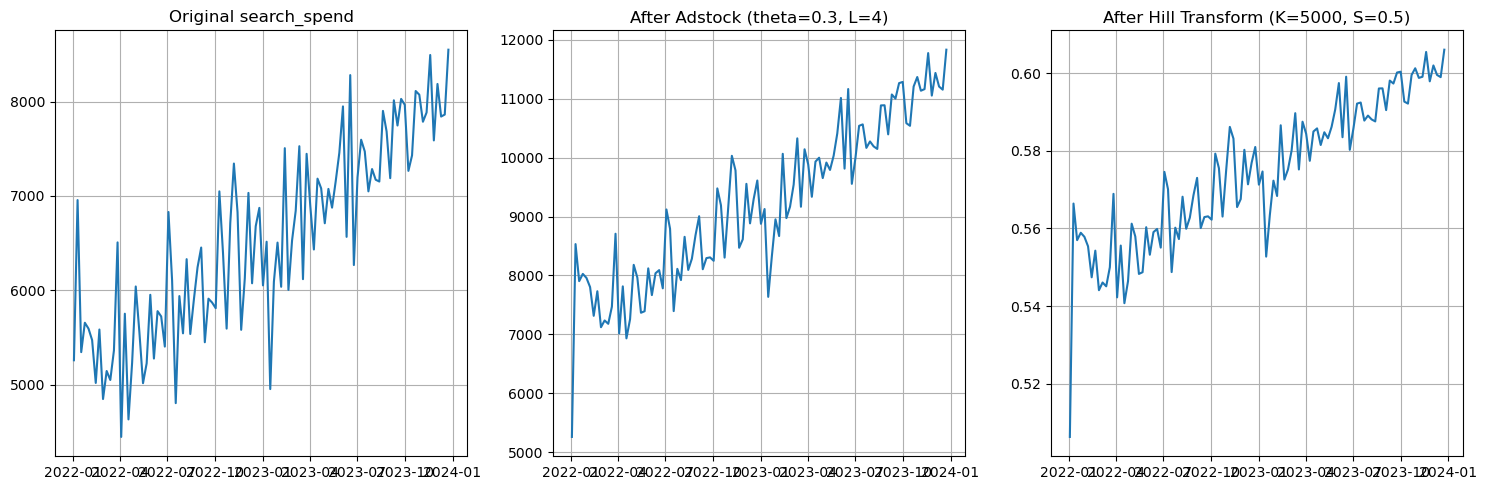

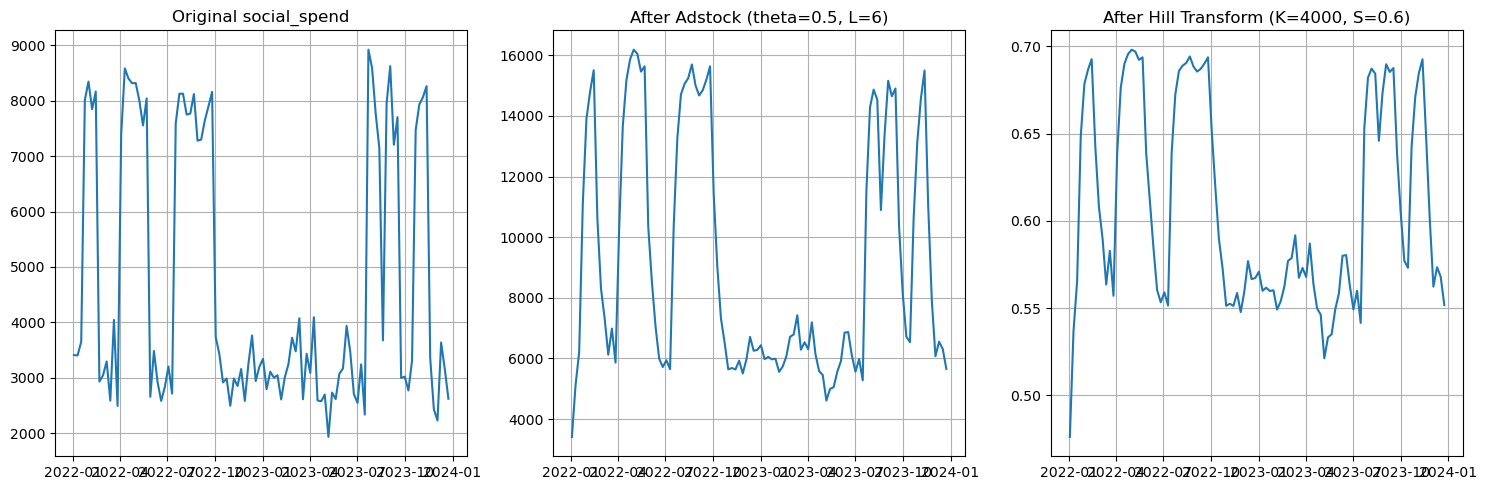

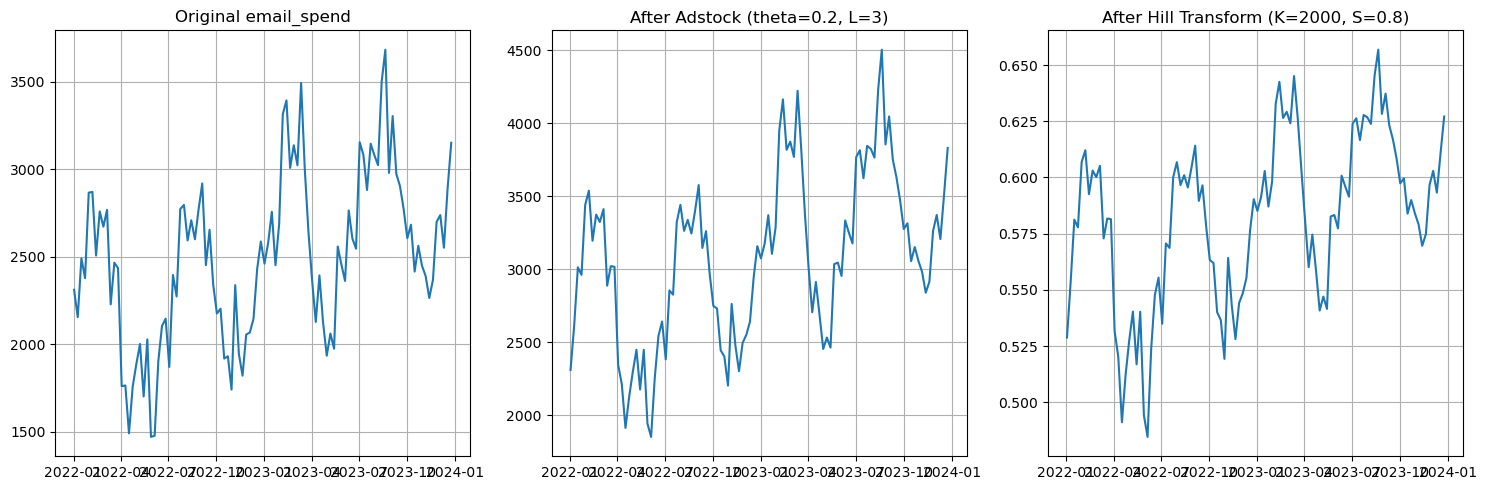

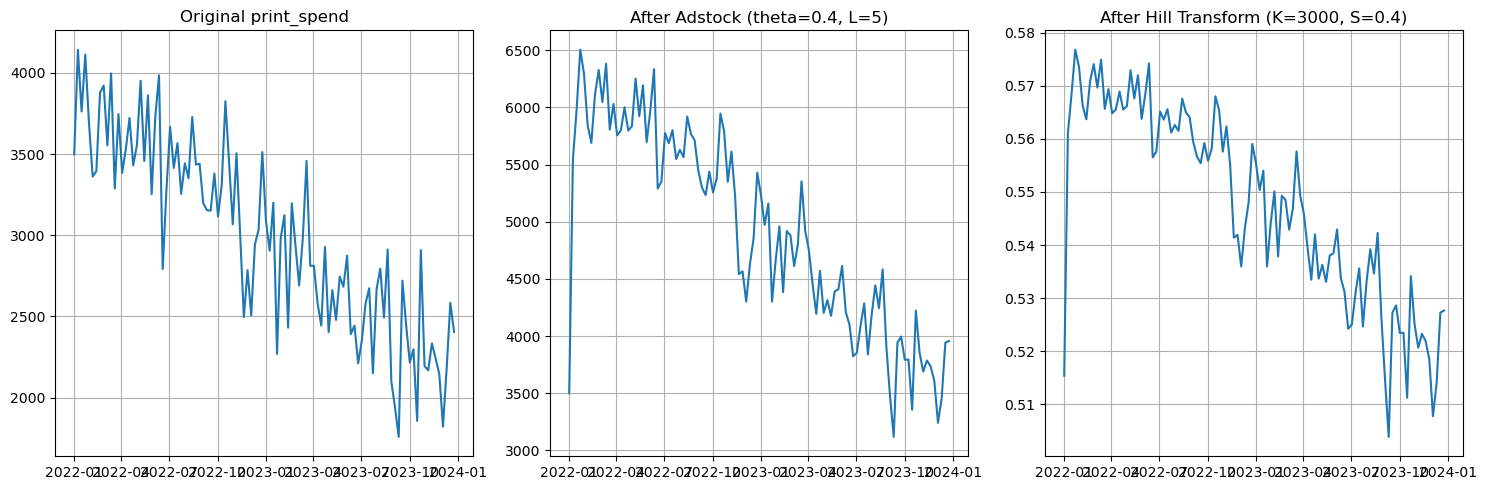

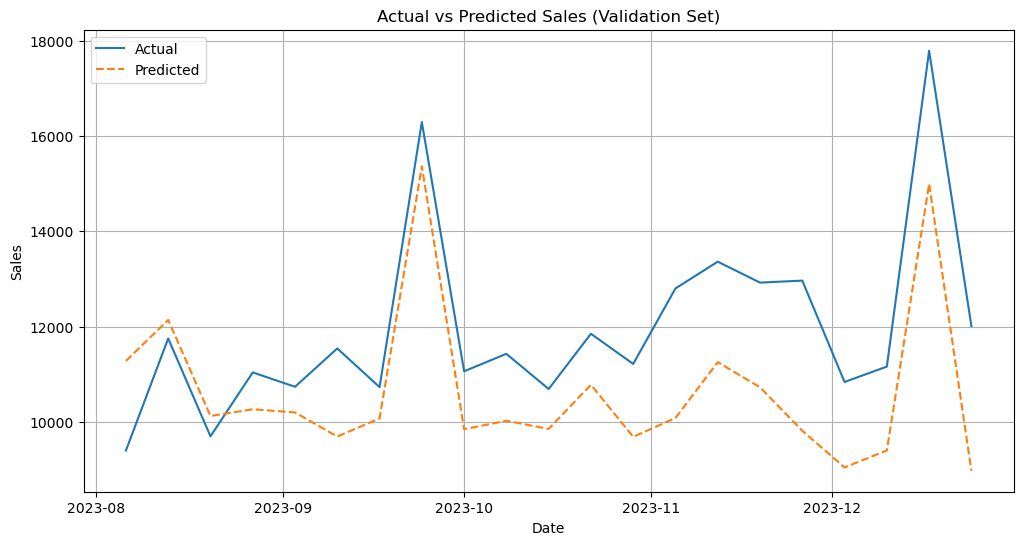

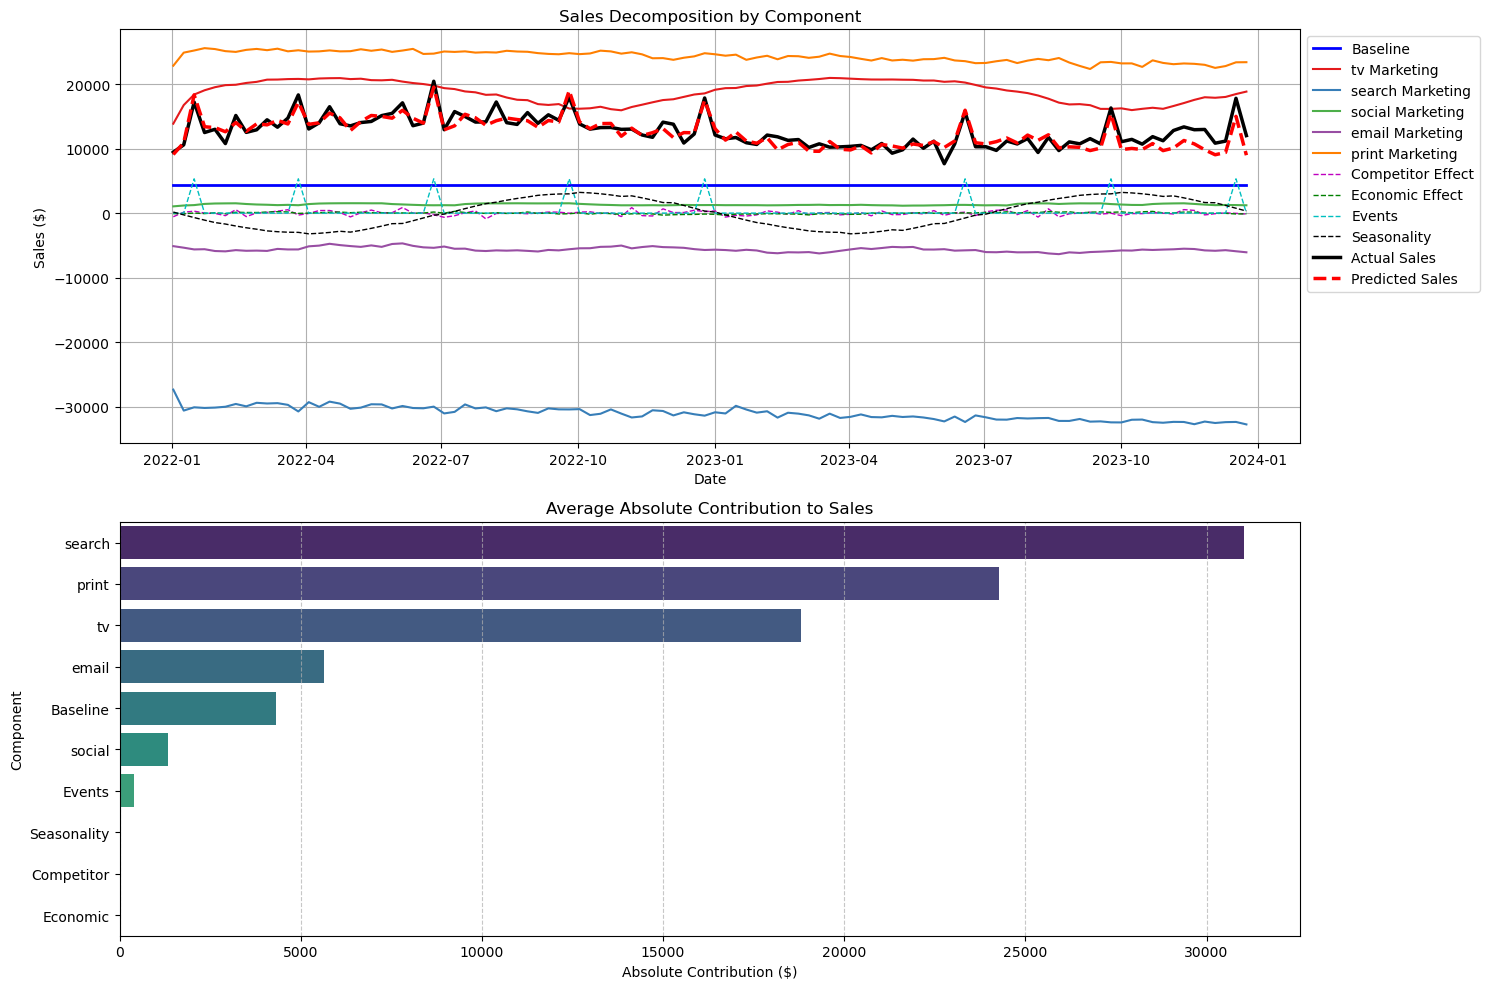

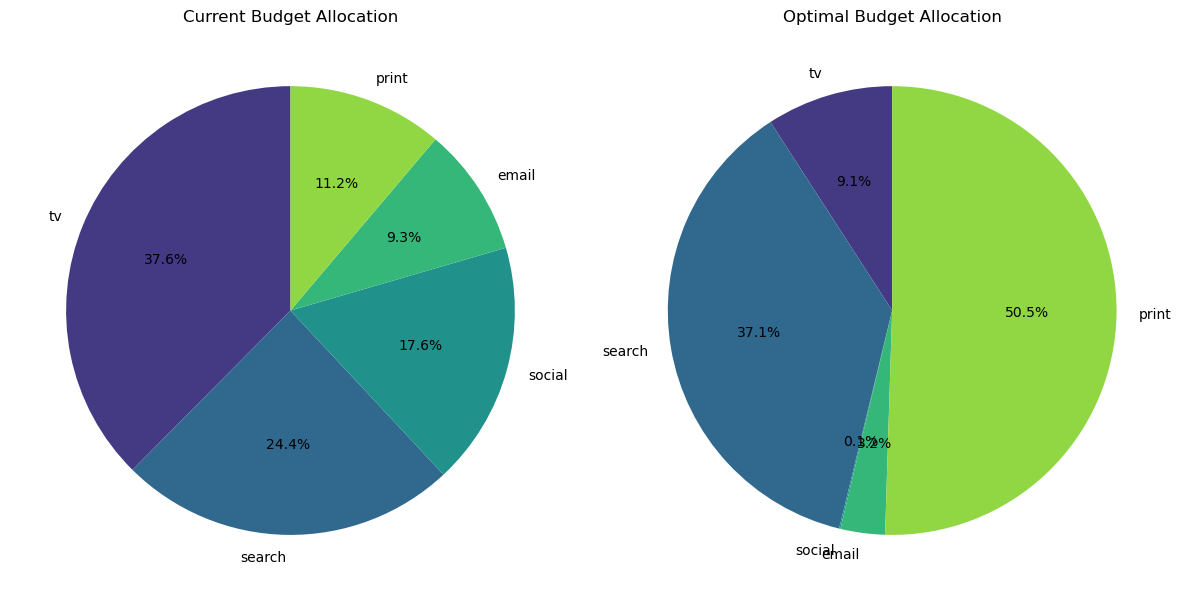

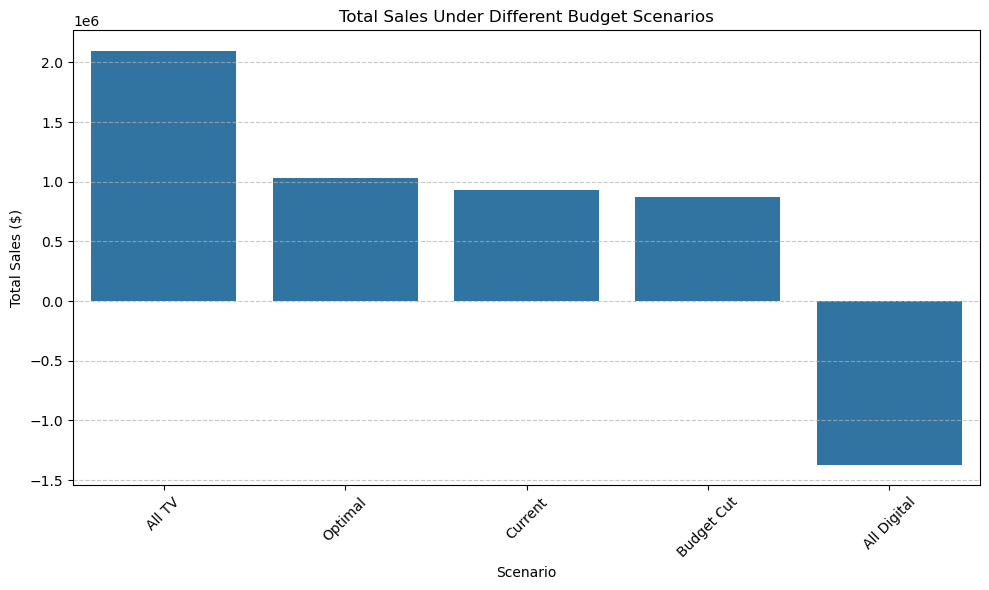

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def run_meridian_mmm(data):
    """
    Run a Meridian-style MMM model on the provided data.
    
    Parameters:
    - data: DataFrame with marketing and sales data
    
    Returns:
    - Dictionary of model results
    """
    print("Running Meridian-style MMM model...")
    
    # Display the data
    print("Loaded marketing mix data with shape:", data.shape)
    print(data.head())

    # Define our key marketing channels
    marketing_channels = ['tv_spend', 'search_spend', 'social_spend', 'email_spend', 'print_spend']

    # 1. Implementing Geometric Adstock (similar to Meridian's approach)
    def geometric_adstock(x, theta, L):
        """
        Apply geometric adstock transformation (used in Meridian)
        
        Parameters:
        - x: array, marketing data
        - theta: float, decay rate between 0 and 1
        - L: int, maximum lag
        
        Returns:
        - array, transformed data with adstock applied
        """
        n = len(x)
        y = np.zeros(n)
        
        for i in range(n):
            for l in range(min(i+1, L)):
                y[i] += x[i-l] * (theta ** l)
        
        return y

    # 2. Implementing Hill/S-curve functions for diminishing returns
    def hill_transform(x, K, S):
        """
        Apply Hill transformation for diminishing returns (similar to Meridian)
        
        Parameters:
        - x: array, marketing data
        - K: float, half-saturation constant
        - S: float, shape parameter
        
        Returns:
        - array, transformed data with diminishing returns
        """
        return x**S / (K**S + x**S)

    # Simulate Meridian preprocessing pipeline
    print("Preprocessing data with Meridian-like transformations...")

    # Store transformed features
    transformed_data = data.copy()

    # Apply transformations to each marketing channel
    for channel in marketing_channels:
        # Parameters for each channel (in real Meridian, these would be optimized)
        # These are example parameters
        if channel == 'tv_spend':
            theta, L = 0.7, 8  # TV has high carryover
            K, S = 10000, 0.7  # TV has strong diminishing returns
        elif channel == 'search_spend':
            theta, L = 0.3, 4  # Search has lower carryover
            K, S = 5000, 0.5   # Search has moderate diminishing returns
        elif channel == 'social_spend':
            theta, L = 0.5, 6  # Social has medium carryover
            K, S = 4000, 0.6   # Medium diminishing returns
        elif channel == 'email_spend':
            theta, L = 0.2, 3  # Email has low carryover
            K, S = 2000, 0.8   # High efficiency (less diminishing returns)
        else:  # print_spend
            theta, L = 0.4, 5  # Print has medium carryover
            K, S = 3000, 0.4   # Strong diminishing returns
        
        # Apply adstock (carryover effect)
        transformed_data[f'{channel}_adstock'] = geometric_adstock(
            transformed_data[channel].values, theta, L
        )
        
        # Apply hill transform (diminishing returns)
        transformed_data[f'{channel}_transformed'] = hill_transform(
            transformed_data[f'{channel}_adstock'].values, K, S
        )
        
        # Plot the transformations
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(transformed_data['date'], transformed_data[channel], label='Original')
        plt.title(f'Original {channel}')
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(transformed_data['date'], transformed_data[f'{channel}_adstock'], label='Adstock')
        plt.title(f'After Adstock (theta={theta}, L={L})')
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(transformed_data['date'], transformed_data[f'{channel}_transformed'], label='Final')
        plt.title(f'After Hill Transform (K={K}, S={S})')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'{channel}_transformations.png')

    # Handle control variables
    transformed_data['competitor_activity_scaled'] = StandardScaler().fit_transform(
        transformed_data[['competitor_activity']]
    )
    transformed_data['economic_factor_scaled'] = StandardScaler().fit_transform(
        transformed_data[['economic_factor']]
    )

    # Handle seasonality (similar to Meridian's Fourier series approach)
    transformed_data['month_sin'] = np.sin(2 * np.pi * transformed_data['month'] / 12)
    transformed_data['month_cos'] = np.cos(2 * np.pi * transformed_data['month'] / 12)
    transformed_data['week_sin'] = np.sin(2 * np.pi * transformed_data['week_of_year'] / 52)
    transformed_data['week_cos'] = np.cos(2 * np.pi * transformed_data['week_of_year'] / 52)

    # Prepare features for the model
    features = [f'{channel}_transformed' for channel in marketing_channels]
    features += ['competitor_activity_scaled', 'economic_factor_scaled', 
                'month_sin', 'month_cos', 'week_sin', 'week_cos', 'events']

    # Split data for training and validation
    train_size = int(len(transformed_data) * 0.8)
    train_data = transformed_data[:train_size]
    valid_data = transformed_data[train_size:]

    # Print feature names
    print("\nFeatures used in the model:")
    for f in features:
        print(f"- {f}")

    # Building the model (using statsmodels for detailed statistics)
    X_train = sm.add_constant(train_data[features])
    y_train = train_data['sales']

    X_valid = sm.add_constant(valid_data[features])
    y_valid = valid_data['sales']

    # Fit the model
    print("\nFitting Meridian-style model...")
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())

    # Make predictions on validation set
    y_pred = model.predict(X_valid)

    # Calculate validation metrics
    mae = np.mean(np.abs(y_valid - y_pred))
    rmse = np.sqrt(np.mean((y_valid - y_pred) ** 2))
    mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
    r2 = 1 - np.sum((y_valid - y_pred) ** 2) / np.sum((y_valid - y_valid.mean()) ** 2)

    print(f"\nValidation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(valid_data['date'], y_valid, label='Actual')
    plt.plot(valid_data['date'], y_pred, label='Predicted', linestyle='--')
    plt.title('Actual vs Predicted Sales (Validation Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.savefig('mmm_validation_predictions.png')

    # Decomposition analysis (similar to Meridian's decomposition)
    # This helps understand what portion of sales is attributed to each factor
    print("\nPerforming sales decomposition analysis...")

    # Predict on the entire dataset
    X_full = sm.add_constant(transformed_data[features])
    y_full_pred = model.predict(X_full)

    # Get the coefficients
    coef = model.params

    # Calculate baseline/intercept contribution
    intercept_contribution = coef['const'] * np.ones_like(transformed_data['sales'])

    # Calculate contribution of each marketing channel
    channel_contributions = {}
    for channel in marketing_channels:
        feature = f'{channel}_transformed'
        # Extract the channel name without '_spend'
        channel_name = channel.replace('_spend', '')
        channel_contributions[channel_name] = coef[feature] * transformed_data[feature]

    # Calculate contribution of control variables
    control_contributions = {
        'competitor': coef['competitor_activity_scaled'] * transformed_data['competitor_activity_scaled'],
        'economic': coef['economic_factor_scaled'] * transformed_data['economic_factor_scaled'],
        'events': coef['events'] * transformed_data['events']
    }

    # Calculate seasonal contributions
    # Combining sine and cosine terms to get total seasonality effect
    seasonal_contribution = (
        coef['month_sin'] * transformed_data['month_sin'] +
        coef['month_cos'] * transformed_data['month_cos'] +
        coef['week_sin'] * transformed_data['week_sin'] +
        coef['week_cos'] * transformed_data['week_cos']
    )

    # Aggregate all contributions
    all_contributions = pd.DataFrame({
        'date': transformed_data['date'],
        'sales': transformed_data['sales'],
        'baseline': intercept_contribution
    })

    # Add marketing channel contributions
    for channel, contribution in channel_contributions.items():
        all_contributions[channel] = contribution

    # Add control variable contributions
    for control, contribution in control_contributions.items():
        all_contributions[control] = contribution
        
    # Handle seasonality separately since it can be positive or negative
    all_contributions['seasonality'] = seasonal_contribution

    # Calculate total predicted sales
    all_contributions['predicted_sales'] = all_contributions.drop(['date', 'sales'], axis=1).sum(axis=1)

    # Plot the decomposition using a safer approach with individual line plots
    plt.figure(figsize=(15, 10))

    # First subplot for decomposition over time
    ax = plt.subplot(211)
    
    # Instead of stacked area, use individual line plots
    plt.plot(all_contributions['date'], all_contributions['baseline'], 'b-', label='Baseline', linewidth=2)
    
    # Plot marketing channels
    colors = sns.color_palette('Set1', len(channel_contributions))
    for i, (channel, contribution) in enumerate(channel_contributions.items()):
        plt.plot(all_contributions['date'], contribution, color=colors[i], label=f'{channel} Marketing', linewidth=1.5)
    
    # Plot other components
    plt.plot(all_contributions['date'], all_contributions['competitor'], 'm--', label='Competitor Effect', linewidth=1)
    plt.plot(all_contributions['date'], all_contributions['economic'], 'g--', label='Economic Effect', linewidth=1)
    plt.plot(all_contributions['date'], all_contributions['events'], 'c--', label='Events', linewidth=1)
    plt.plot(all_contributions['date'], all_contributions['seasonality'], 'k--', label='Seasonality', linewidth=1)
    
    # Plot actual and predicted sales
    plt.plot(all_contributions['date'], all_contributions['sales'], 'k-', label='Actual Sales', linewidth=2.5)
    plt.plot(all_contributions['date'], all_contributions['predicted_sales'], 'r--', label='Predicted Sales', linewidth=2.5)
    
    plt.title('Sales Decomposition by Component')
    plt.xlabel('Date')
    plt.ylabel('Sales ($)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Create a stacked bar plot for average contributions
    plt.subplot(212)
    
    # Calculate average absolute contributions to show relative importance
    avg_abs_contributions = pd.Series({
        'Baseline': abs(all_contributions['baseline'].mean()),
        'Seasonality': abs(all_contributions['seasonality'].mean()),
        'Competitor': abs(all_contributions['competitor'].mean()),
        'Economic': abs(all_contributions['economic'].mean()),
        'Events': abs(all_contributions['events'].mean())
    })
    
    # Add marketing channels
    for channel in channel_contributions.keys():
        avg_abs_contributions[f'{channel}'] = abs(all_contributions[channel].mean())
    
    # Sort by contribution size
    avg_abs_contributions = avg_abs_contributions.sort_values(ascending=False)
    
    # Plot bar chart
    sns.barplot(x=avg_abs_contributions.values, y=avg_abs_contributions.index, palette='viridis')
    plt.title('Average Absolute Contribution to Sales')
    plt.xlabel('Absolute Contribution ($)')
    plt.ylabel('Component')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('sales_decomposition.png')

    # Calculate elasticities and ROI for each marketing channel
    print("\nCalculating marketing elasticities and ROI...")

    # Function to calculate elasticity
    def calculate_elasticity(model, feature, X, y):
        """Calculate the elasticity of a feature"""
        coef = model.params[feature]
        avg_feature = X[feature].mean()
        avg_y = y.mean()
        
        # Elasticity formula: (∂y/∂x) * (x/y)
        # For our transformed features, we need to consider the transformation
        elasticity = coef * (avg_feature / avg_y)
        return elasticity

    # Calculate elasticities
    elasticities = {}
    for channel in marketing_channels:
        transformed_feature = f'{channel}_transformed'
        channel_name = channel.replace('_spend', '')
        elasticities[channel_name] = calculate_elasticity(model, transformed_feature, X_train, y_train)

    # Calculate mROI (marginal Return on Investment)
    roi_values = {}
    channel_spend = transformed_data[marketing_channels].mean()

    for channel in marketing_channels:
        # Get channel name without "_spend"
        channel_name = channel.replace('_spend', '')
        # Average contribution
        avg_contrib = channel_contributions[channel_name].mean()
        # Average spend
        avg_spend = channel_spend[channel]
        # ROI = contribution / spend
        roi_values[channel_name] = avg_contrib / avg_spend

    # Print elasticities and ROI
    print("\nMarketing Channel Elasticities:")
    for channel, elasticity in elasticities.items():
        print(f"{channel}: {elasticity:.4f}")

    print("\nMarketing Channel ROI (return per $1 spent):")
    for channel, roi in roi_values.items():
        print(f"{channel}: ${roi:.2f}")

    # Budget optimization (similar to Meridian's optimization)
    print("\nPerforming budget optimization...")

    # Current total marketing budget
    current_budget = transformed_data[marketing_channels].sum().sum() / len(transformed_data)
    print(f"Current average weekly marketing budget: ${current_budget:.2f}")

    # Optimize based on elasticities and ROI
    # This is a simplified version of Meridian's optimization
    def optimize_budget(total_budget, channels, elasticities, roi_values):
        """
        Simple budget allocation based on elasticities and ROI
        In a full Meridian implementation, this would use more complex optimization
        """
        # Combine elasticity and ROI for ranking
        effectiveness = {}
        for channel_name in elasticities.keys():
            effectiveness[channel_name] = elasticities[channel_name] * roi_values[channel_name]
        
        # Normalize to get proportions
        total_effect = sum(abs(e) for e in effectiveness.values())
        proportions = {channel: abs(eff)/total_effect for channel, eff in effectiveness.items()}
        
        # Allocate budget
        allocation = {channel: total_budget * prop for channel, prop in proportions.items()}
        return allocation

    # Run the optimization
    simple_channel_names = [ch.replace('_spend', '') for ch in marketing_channels]
    optimal_budget = optimize_budget(current_budget, simple_channel_names, elasticities, roi_values)

    # Current vs. optimal allocation
    current_allocation = {}
    for channel in marketing_channels:
        channel_name = channel.replace('_spend', '')
        current_allocation[channel_name] = transformed_data[channel].mean()

    # Print the allocations
    print("\nCurrent vs. Optimal Weekly Budget Allocation:")
    for channel_name in current_allocation.keys():
        curr = current_allocation[channel_name]
        opt = optimal_budget[channel_name]
        change = (opt - curr) / curr * 100
        print(f"{channel_name}: ${curr:.2f} -> ${opt:.2f} ({change:+.1f}%)")

    # Plot current vs. optimal allocation
    plt.figure(figsize=(12, 6))

    # Current allocation
    plt.subplot(1, 2, 1)
    plt.pie(list(current_allocation.values()), labels=current_allocation.keys(), autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(marketing_channels)))
    plt.title('Current Budget Allocation')

    # Optimal allocation
    plt.subplot(1, 2, 2)
    plt.pie(list(optimal_budget.values()), labels=optimal_budget.keys(), autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(marketing_channels)))
    plt.title('Optimal Budget Allocation')

    plt.tight_layout()
    plt.savefig('budget_optimization.png')

    # Scenario analysis (what-if scenarios)
    print("\nPerforming scenario analysis...")

    # Function to predict sales under different budget scenarios
    def predict_sales_for_scenario(base_data, model, features, marketing_channels, budget_multipliers):
        """
        Predict sales for a given budget scenario
        
        Parameters:
        - base_data: DataFrame with the original data
        - model: trained model
        - features: list of feature names
        - marketing_channels: list of marketing channel names
        - budget_multipliers: dict mapping channels to their budget multipliers
        
        Returns:
        - predicted sales
        """
        # Create a copy of the data
        scenario_data = base_data.copy()
        
        # Apply budget multipliers to marketing channels
        for channel, multiplier in budget_multipliers.items():
            # Get the full channel name
            full_channel = f"{channel}_spend" if not channel.endswith('_spend') else channel
            
            # Adjust the raw spend
            scenario_data[full_channel] = scenario_data[full_channel] * multiplier
            
            # Re-apply the transformations
            # In a real implementation, you'd use Meridian's pipeline
            # This is a simplification
            theta, L = 0.5, 4  # Default parameters
            K, S = 5000, 0.6   # Default parameters
            
            # Apply transformations
            scenario_data[f'{full_channel}_adstock'] = geometric_adstock(
                scenario_data[full_channel].values, theta, L
            )
            scenario_data[f'{full_channel}_transformed'] = hill_transform(
                scenario_data[f'{full_channel}_adstock'].values, K, S
            )
        
        # Prepare features for prediction
        X_scenario = sm.add_constant(scenario_data[features])
        
        # Make prediction
        return model.predict(X_scenario)

    # Define scenarios
    scenarios = {
        'Current': {channel_name: 1.0 for channel_name in simple_channel_names},
        'Optimal': {channel_name: optimal_budget[channel_name]/current_allocation[channel_name] 
                for channel_name in simple_channel_names},
        'All TV': {channel_name: 0.1 if channel_name != 'tv' else 5.0 
               for channel_name in simple_channel_names},
        'All Digital': {'tv': 0.2, 'print': 0.2, 
                    'search': 2.0, 'social': 2.0, 'email': 2.0},
        'Budget Cut': {channel_name: 0.7 for channel_name in simple_channel_names}
    }

    # Run scenarios
    scenario_results = {}
    for name, multipliers in scenarios.items():
        scenario_results[name] = predict_sales_for_scenario(
            transformed_data, model, features, marketing_channels, multipliers
        ).sum()

    # Print scenario results
    print("\nScenario Analysis Results (Total Sales):")
    for scenario, total_sales in scenario_results.items():
        pct_change = (total_sales / scenario_results['Current'] - 1) * 100
        print(f"{scenario} Budget: ${total_sales:,.2f} ({pct_change:+.1f}%)")

    # Plot scenario comparison
    plt.figure(figsize=(10, 6))
    scenarios_df = pd.DataFrame({
        'Scenario': list(scenario_results.keys()),
        'Total Sales': list(scenario_results.values())
    })
    scenarios_df = scenarios_df.sort_values('Total Sales', ascending=False)

    sns.barplot(x='Scenario', y='Total Sales', data=scenarios_df)
    plt.title('Total Sales Under Different Budget Scenarios')
    plt.ylabel('Total Sales ($)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('scenario_analysis.png')

    print("\nMeridian-style MMM analysis complete!")
    
    # Return results
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'elasticities': elasticities,
        'roi_values': roi_values,
        'optimal_allocation': optimal_budget,
        'scenario_results': scenario_results
    }

if __name__ == "__main__":
    # If run as a script, load data and run the model
    data = pd.read_csv('synthetic_mmm_data.csv')
    data['date'] = pd.to_datetime(data['date'])
    run_meridian_mmm(data)